In [7]:
%config Completer.use_jedi = False

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, dump, load
import time
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import NMF
from mne.viz import plot_connectivity_circle
from sklearn.decomposition import PCA


#import torch
from hummingbird.ml import convert, load #https://github.com/microsoft/hummingbird
# hummingbird is usefull when you have trained model and you need to speed up prediction step
# it doesn't have nmf

from utils import load_file
from utils import DataResize
from utils import DeltaF
from utils import NMFCV
from utils import video_player
from utils import blob_labeling, image_threshold
from utils import plot_nmf_ROIs
from utils import Connectivity

### User inputs

In [2]:
# data address
h5_add_wt = ['I:/P6 Project/Data and Analyses/Control/210126_P5_scn2a_minus/h5/run3_LED17ma_1h55min_small obj.h5',
          'I:/P6 Project/Data and Analyses/Control/210126_P5_scn2a_minus/h5/run4_LED17ma_2h11min_small obj.h5',
          'I:/P6 Project/Data and Analyses/Control/210126_P5_scn2a_minus/h5/run5_LED17ma_2h24min_small obj.h5']

### Data loading

In [3]:
# load data
data = load_file(add=h5_add_wt[0], key_name = 'GroupHierarchy.Groups.Datasets')

C:\Users\admin\Documents\Python Scripts\P6 Project\Calcium-imaging-data-analysis\utils.py:120: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  file = h5.File(add)


selected file size: (48000, 256, 256)


### Preprocessing

In [4]:
# resizing data 
data = DataResize(data=data, dim=(128,128)).transform()
print(f'new data size: {data.shape}')

new data size: (48000, 128, 128)


#### Load resize of multiple data

In [3]:
# with 3 temporal and 0.5 spatial downsample
data = [DataResize(data = load_file(add=single_add, key_name = 'GroupHierarchy.Groups.Datasets')[::3], 
                        dim=(128,128)).transform() for single_add in h5_add_wt]

C:\Users\admin\Documents\Python Scripts\P6 Project\Calcium-imaging-data-analysis\utils.py:121: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  file = h5.File(add)


selected file size: (48000, 256, 256)
selected file size: (48000, 256, 256)
selected file size: (48000, 256, 256)


### Deltaf analysis

In [4]:
deltaf_list = []
for sub_data in data:
    deltaf = DeltaF(data=sub_data.reshape(-1, 128*128), prct=40).run_on_matrix()
    deltaf = np.where(deltaf<=0, .0000001, deltaf)
    deltaf_list.append(deltaf.reshape(-1, 128,128))

100%|████████████████████████████████████| 16384/16384 [04:38<00:00, 58.84it/s]


In [5]:
# combining data
data = np.vstack(data)
print(f'data size {data.shape}')

deltaf = np.vstack(deltaf_list)
print(f'deltaf data size {deltaf.shape}')

data size (48000, 128, 128)
deltaf data size (48000, 128, 128)


In [5]:
# saving deltaf
np.save('./data/wt_210126_P5_scn2a_minus_run345_deltaf', deltaf)

In [17]:
# loading data
deltaf = np.load("./data/wt_210126_P5_scn2a_minus_run345_deltaf.npy")
print(deltaf.shape)

(16000, 16384)


Text(0.5, 1.0, 'average of deltaf data in time (frames)')

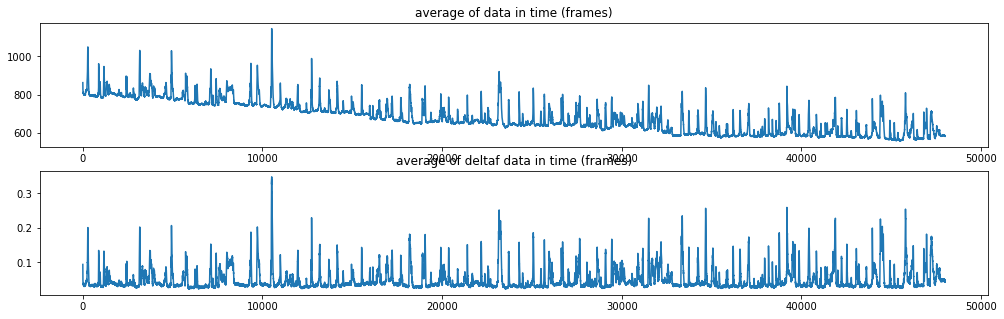

In [7]:
# checking raw data

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(17, 5))

ax0.plot(np.mean(np.mean(data ,axis = 1), axis = 1))
ax0.set_title('average of data in time (frames)')

ax1.plot(np.mean(np.mean(deltaf ,axis = 1), axis = 1))
ax1.set_title('average of deltaf data in time (frames)')

### PCA based artifact removal

In [7]:
data_mean = np.mean(deltaf, axis = 0)
pca_nr_components = 200

pca = PCA(n_components=pca_nr_components)
traces = pca.fit_transform((deltaf - data_mean).reshape(-1, 128*128))
pca_components = pca.components_
print(f"shape of components {pca_components.shape}, shape of traces {traces.shape}")

shape of components (200, 16384), shape of traces (48000, 200)


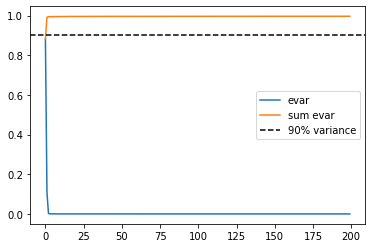

In [8]:
# explained variance
plt.plot(pca.explained_variance_ratio_, label = 'evar')
plt.plot(np.cumsum(pca.explained_variance_ratio_), label = 'sum evar')
plt.axhline(y=0.9, color='black', linestyle='--', label = '90% variance')
plt.legend()

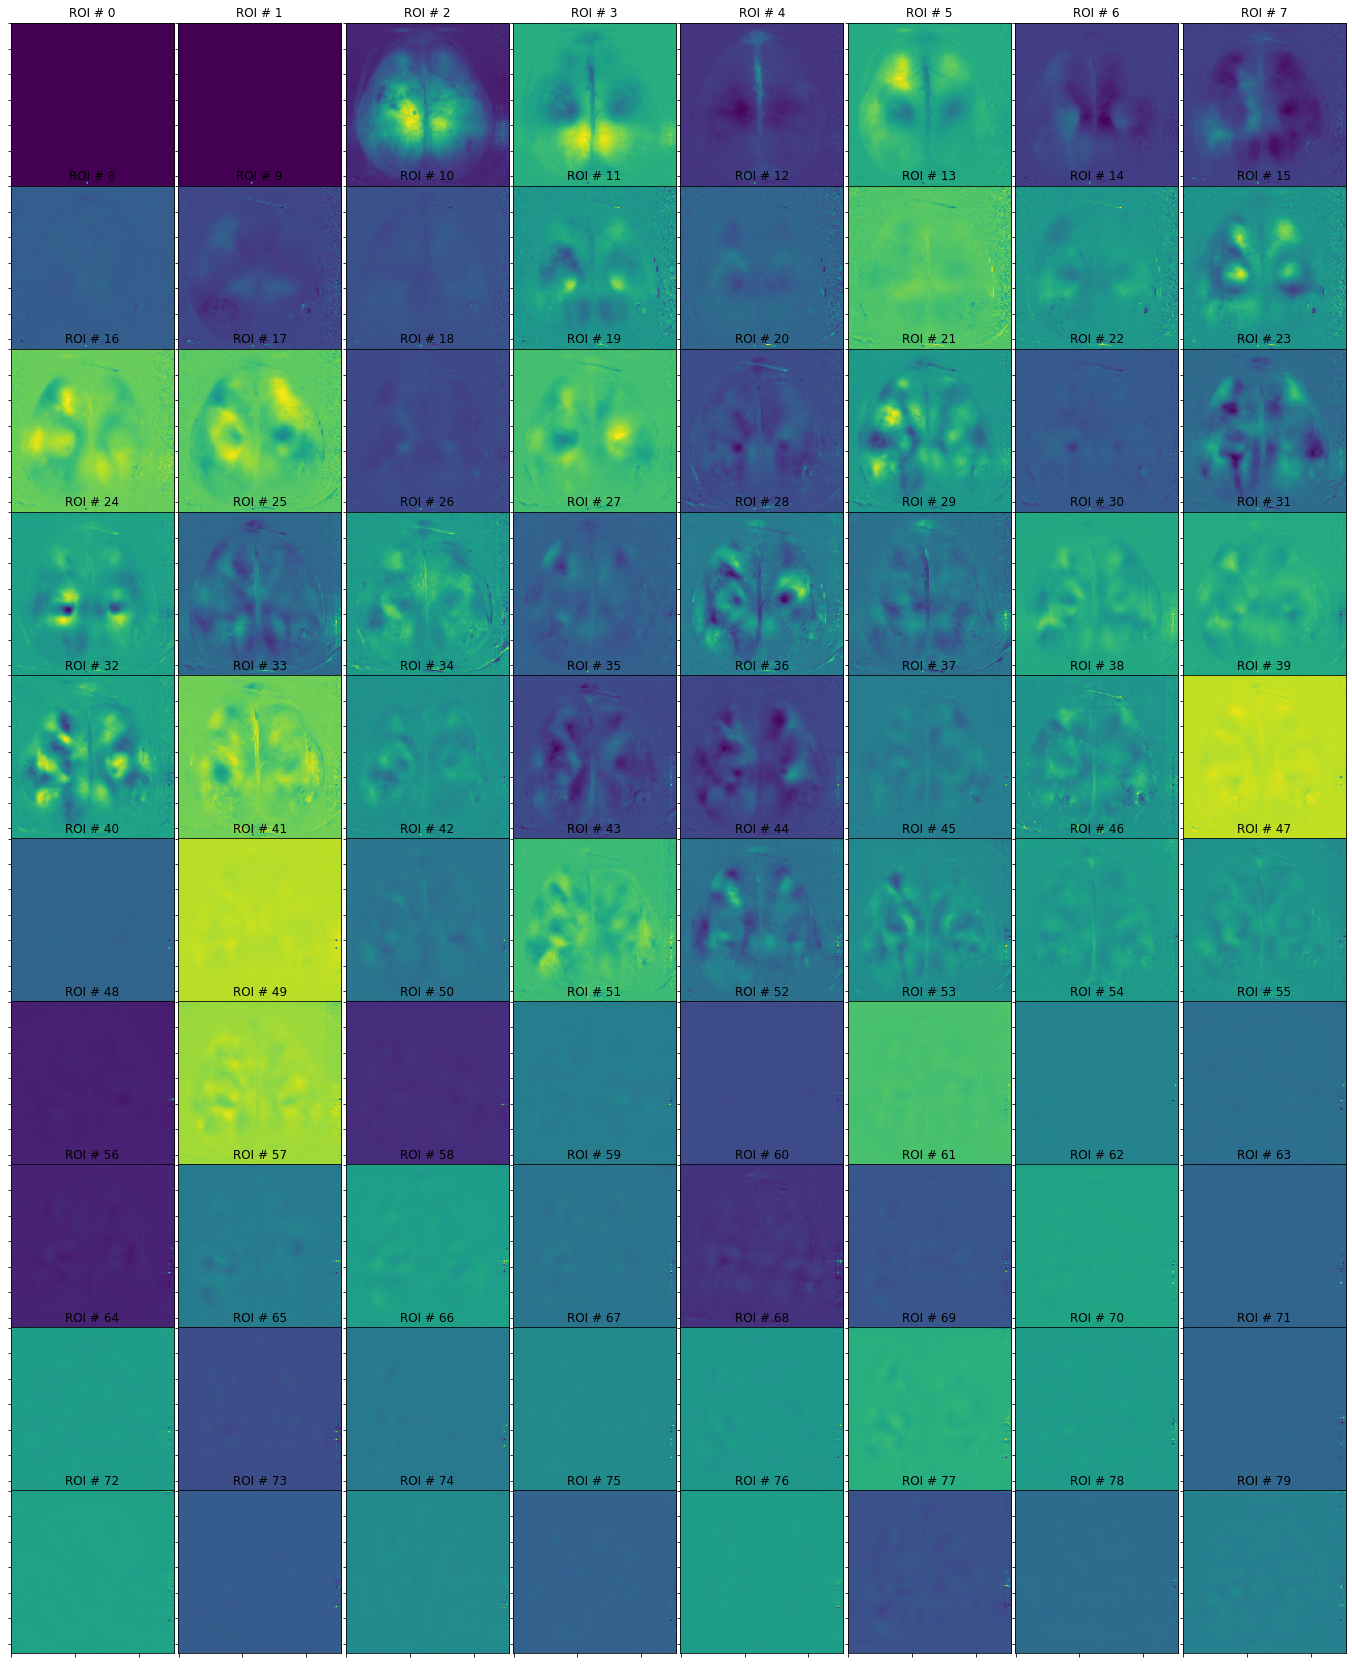

In [9]:
# plotting PCA compoenents
fig, axes = plt.subplots(nrows=10, ncols=8, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace':0}, figsize=(24,30))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_components.reshape(-1, 128, 128)[i])
    ax.set_title(f"ROI # {int(i)}")
    ax.set_xticklabels([])
    ax.set_yticklabels([])


In [10]:
pca_excludes = np.array([0, 1], dtype=int)
pca_selected = np.delete(np.arange(pca_nr_components, dtype=int), pca_excludes).astype(np.int)

# reconstruct without artifacts
pca_rec = np.dot(traces[:, pca_selected], pca_components[pca_selected, :])

# reshape to data
data = pca_rec.reshape(-1, 128, 128) + data_mean

# if data has negative values
data = np.where(data<0, 0.00001, data)

Text(0.5, 1.0, 'average of data in time (frames)')

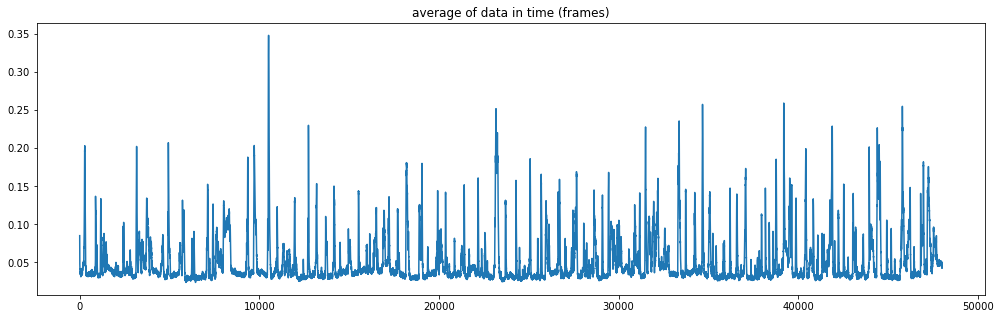

In [11]:
# checking raw data after pca application

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 5))
ax.plot(np.mean(np.mean(data,axis = 1), axis = 1))
ax.set_title('average of data in time (frames)')

### Feature selection

Text(0.5, 1.0, 'Max Projection')

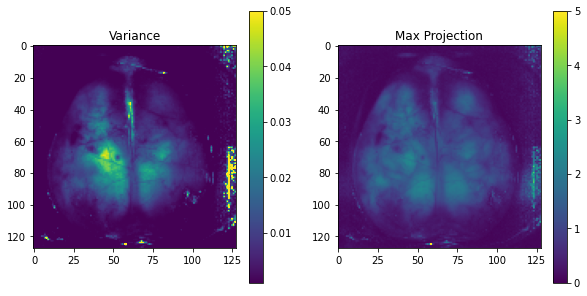

In [12]:
# feature selection

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# (1) check variance in the video
plot1 = ax1.imshow(np.var(data, axis=0), vmin = .001, vmax = .05)
plt.colorbar(plot1, ax = ax1)
ax1.set_title('Variance')

plot2 = ax2.imshow(np.max(data, axis=0), vmin = 0, vmax = 5)
plt.colorbar(plot2, ax = ax2)
ax2.set_title('Max Projection')

In [13]:
from sklearn.feature_selection import VarianceThreshold

n, p1, p2 = data.shape

# initialize class with user given threshold
var_feature = VarianceThreshold(threshold=0.001)

# fit on data
var_feature.fit(data.reshape(n, p1 * p2))

# transform data
feature_selected = var_feature.transform(data.reshape(n, p1 * p2))


print(f'selected feature shape for given threshold: {feature_selected.shape}')

selected feature shape for given threshold: (48000, 10000)


reconstructed data size: (48000, 128, 128) 



HINT: PLEASE NOTICE THAT, X with columns of zeros inserted where features would have been removed by transform


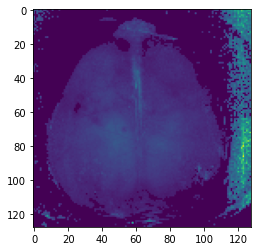

In [14]:
# reconstructing back data
data_rec = var_feature.inverse_transform(feature_selected)

# reshape back data to 3d tensor
data_rec = data_rec.reshape(n, p1, p2)

plt.imshow(np.mean(data_rec, axis=0))
print(f'reconstructed data size: {data_rec.shape} \n\n\n')
print('HINT: PLEASE NOTICE THAT, X with columns of zeros inserted where features would have been removed by transform')

In [ ]:
# if you want to get selected indices
var_feature.get_support()

In [19]:
# saving variance model
dump(var_feature, './results/models/wt_210126_P5_scn2a_minus_run345_var_features')

['./results/models/wt_210126_P5_scn2a_minus_run345_var_features']

In [21]:
# loading variance model
var_feature = load('./results/models/wt_210126_P5_scn2a_minus_run345_var_features')

In [19]:
# saving selected features
np.save('./data/wt_210126_P5_scn2a_minus_run345_selected_features', feature_selected)

In [2]:
# loading data
feature_selected = np.load("./data/wt_210126_P5_scn2a_minus_run345_selected_features.npy")
print(feature_selected.shape)

(48000, 9622)


### Video check (VAR :))

In [30]:
data_rec = var_feature.inverse_transform(deltaf)
data_rec.shape

(48000, 16384)

In [32]:
video_player(np_array_video=data_rec.reshape(-1, 128, 128)[1000:2000], cmin=0.0, cmax=0.4, intervals_=100)

### Decomposition

#### Number of components estimation Type1

In [ ]:
nmf_cv = NMFCV(data=deltaf[::3], use_feature_selection=False, threshold=False)
cv_result = nmf_cv.estimate_componentsV1(use_parallel=True, n_jobs=3, nr_replicates=5, nr_components=(5,80,5), n_iters=200)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 106.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 588.6min


Component number with minimum test error is 20


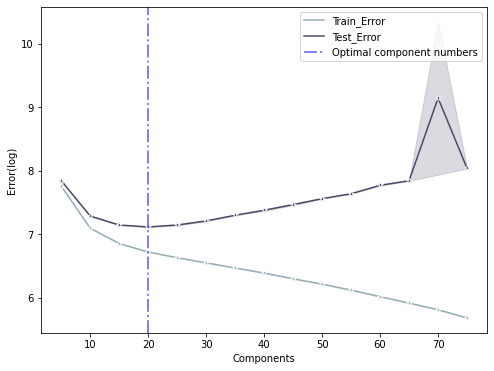

In [8]:
nmf_cv.plot_cv_results(columns = =['Components', 'Replication', 'Train_Error', 'Test_Error'], 
                       min_by = 'Test_Error', save_fig_add='./figures')

#### Number of components estimation Type2

In [4]:
nmf_cv = NMFCV(data=feature_selected, use_feature_selection=False, threshold=False)

start_time = time.clock()
cv_results = nmf_cv.estimate_componentsV2(n_jobs=15, nr_replicates=3, nr_components=[2, 100, 10])

print(f'execution time: {np.rint(time.clock() - start_time)} seconds')


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 tasks      | elapsed: 19.9min
[Parallel(n_jobs=15)]: Done  10 tasks      | elapsed: 74.0min
[Parallel(n_jobs=15)]: Done  20 out of  30 | elapsed: 243.3min remaining: 121.6min
[Parallel(n_jobs=15)]: Done  24 out of  30 | elapsed: 270.2min remaining: 67.5min
[Parallel(n_jobs=15)]: Done  28 out of  30 | elapsed: 379.3min remaining: 27.1min
[Parallel(n_jobs=15)]: Done  30 out of  30 | elapsed: 468.9min finished


execution time: 28211.0 seconds


In [5]:
# saving cv_results
np.save('./results/cv_results/wt_210126_P5_scn2a_minus_run345_cv_result.npy', cv_results)

Component number with minimum test error is 42


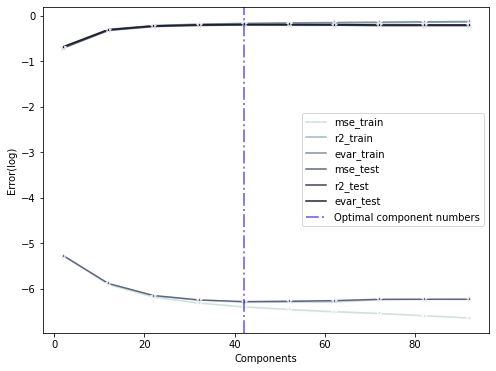

In [6]:
nmf_cv.plot_cv_results(columns =['Components', 'Replication', 'mse_train', 
                                   'r2_train', 'evar_train', 'mse_test', 'r2_test', 'evar_test'], 
                       min_by = 'mse_test', save_fig_add="./figures/wt_210126_P5_scn2a_minus_run345_cv_result.pdf")

#### Number of components estimate Type3

In [ ]:
nmf_cv = NMFCV(data=deltaf, use_feature_selection=False, threshold=False)

start_time = time.clock()
cv_results = nmf_cv.estimate_componentsV3(nmf_type = "Nsnmf", rank_cands=range(2, 150, 5), max_iter = 100)

print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

In [ ]:
nmf_cv.plot_cv_resultsV3(save_fig_add=False)

#### Running NMF
It is good to choose nmf algorithm based on the type of algorithm used to cross-validation

In [22]:
nmf = NMF(n_components=42, init="nndsvd", max_iter=5000, random_state=1)
traces = nmf.fit_transform(feature_selected)
components = nmf.components_
print(f"shape of traces {traces.shape}, shape of components {components.shape}")

shape of traces (48000, 42), shape of components (42, 10000)


In [8]:
# saving nmf model
dump(nmf, "./results/models/wt_210126_P5_scn2a_minus_run345_NMF.joblib")

['./results/models/wt_210126_P5_scn2a_minus_run345_NMF.joblib']

In [ ]:
# loading nmf model
nmf = load('./results/models/wt_210126_P5_scn2a_minus_run234_NMF.joblib')

In [23]:
# loading variance model IF not already exist
var_feature = load('./results/models/wt_210126_P5_scn2a_minus_run345_var_features.joblib')

In [24]:
# return back components to full size
components = var_feature.inverse_transform(components)
print(f"Full size components {components.shape}")

# reshapeing back
components = components.reshape(-1, 128, 128)
print(f"Full size reshaped components {components.shape}")

Full size components (42, 16384)
Full size reshaped components (42, 128, 128)


#### NMF post-processing

In [25]:
# after getting nmf result (components)

# initialize all frames dataframe
ROIs = pd.DataFrame()
binary_ROIs = []
# running on all frames
for i in range(components.shape[0]):
    ROI = blob_labeling(image=image_threshold(img = components[i], threshold=0.3))
    ROI['component_nr'] = i
    ROI['mouse_id'] = "210126_P5_scn2a_minus"
    ROIs = ROIs.append(ROI, ignore_index = True)
    binary_ROIs.append(image_threshold(img = components[i], threshold=0.3))

# make tensor of binary ROIs
binary_ROIs = np.stack(binary_ROIs)

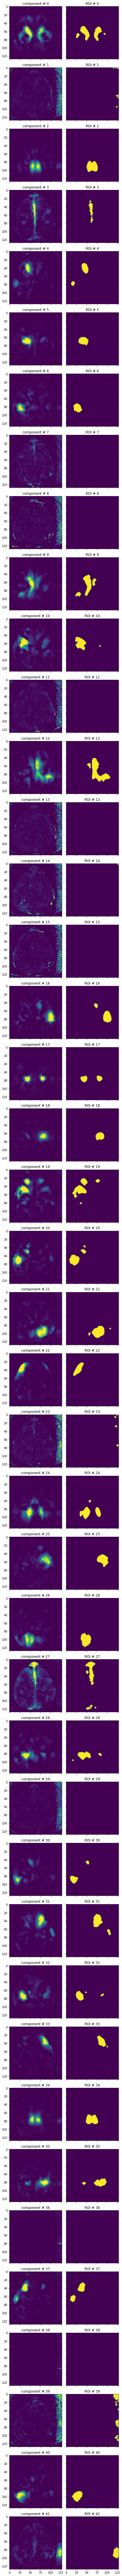

In [26]:
# controling thresholds
plot_nmf_ROIs(components=components, ROIs=binary_ROIs, base_w_size=6, c_min = 0, c_max = 1)

In [27]:
# excluding artifact frames
exclude_frames = [1, 3, 7, 8, 11, 13, 14, 15, 23, 27, 29, 36, 38, 39, 41]

In [28]:
# cleaning ROIs dataframe
min_area = 20
ROIs_clean = ROIs.copy()

# excluding frames
ROIs_clean = ROIs_clean[~ROIs_clean['component_nr'].isin(exclude_frames)]

# filtering area
ROIs_clean = ROIs_clean[ROIs_clean['area'] > min_area]

ROIs_clean

center-y(rows)  center-x(cols)  orientation  area  min_row  min_col  \
0        63.059952       45.964029     0.460236   417       48       34   
1        64.247253       75.890110    -0.254846   364       49       68   
3        70.579710       27.753623    -0.405644    69       65       24   
8        91.440000       62.968696     1.367646   575       78       50   
11       40.719745       45.742038     0.303370   314       29       38   
12       77.924051       16.227848    -0.236744    79       73       12   
13       68.807065       41.964674     1.344367   368       59       30   
14       82.826748       27.465046     0.651900   329       72       18   
15       64.095638       52.513423     0.029197   596       42       41   
16       59.373913       67.530435    -0.189764   115       51       63   
17       89.365385       29.153846    -1.187556   104       84       22   
18       59.480357       34.439286     0.525985   560       44       22   
20       74.221913       77.461467     0.533077  1077       41       63   
21       58.540541       56.094595     0.400890    74       53       51   
23       47.038961       72.441558     0.468757    77       42       68   
24       74.775330       99.841410     0.114444   454       60       90   
25       75.234899       80.738255     0.805590   149       68       74   
26       76.386935       43.281407    -1.464936   199       69       35   
27       67.062500       81.971875    -1.284840   320       58       72   
28       28.599010       43.212871     0.716324   202       21       35   
29       26.691176       76.779412    -1.352703    68       23       72   
30       50.760377       31.481132    -1.202145   530       37       15   
32       37.000000       44.500000     0.493463    22       34       42   
33       49.000000       42.117021     0.996427    94       44       35   
34       70.103158       19.642105     0.033262   475       58        8   
35       96.057364       78.713178    -0.962206   645       82       63   
37      100.906250       56.375000    -0.292175    32       97       54   
38       37.573566       29.743142    -0.592604   401       22       17   
43       61.777778       57.333333    -0.491397    27       59       55   
44       90.381264       46.431373    -0.740917   459       76       33   
45       88.213043       77.495652     0.296927   230       76       71   
46       55.766234       89.434137     0.808909   539       43       75   
47      100.936275       47.410131     0.134442   612       85       35   
52       84.093677       43.543326     1.549486   427       75       28   
53       82.000000       82.441860     0.952753    43       79       78   
55       46.894737       51.982456     0.566455    57       43       48   
56       87.941634       18.256809     0.980214   257       79        9   
57       39.627863       75.742366    -0.138572   524       24       66   
58       67.211765      104.223529     0.371379    85       60      100   
59       73.803077       32.652308     0.513549   325       62       23   
61       71.388889       87.750000    -0.987994    36       68       84   
62       35.426184       85.718663     0.552189   359       22       75   
64       76.625448       62.229391     1.461947   558       65       48   
65       80.775120       83.681818    -1.380625   418       71       68   
66       82.553191       43.276596    -1.454912    47       80       39   
67       38.016949       37.603390    -0.375270   295       26       28   
68       64.889571       16.116564    -0.304975   163       57       10   
75       98.619048       27.308390    -0.732200   441       87       14   

    max_row  max_col                                             coords  \
0        84       57  [[48, 39], [48, 40], [48, 41], [48, 42], [48, ...   
1        85       88  [[49, 80], [50, 76], [50, 77], [50, 78], [50, ...   
3        78       33  [[65, 28], [65, 29], [66, 27], [66, 28], [66, ...   
8       105       77  [[78, 

In [29]:
# saving ROIs
ROIs.to_csv("./results/ROIs/wt_210126_P5_scn2a_minus_run345_ROIsTable.csv", index = False)

In [ ]:
# loading ROIs
ROIs = pd.read_csv("./results/ROIs/wt_210126_P5_scn2a_minus_run345_ROIsTable.csv")

In [30]:
ROIs.head(3)

center-y(rows)  center-x(cols)  orientation  area  min_row  min_col  \
0       63.059952       45.964029     0.460236   417       48       34   
1       64.247253       75.890110    -0.254846   364       49       68   
2       66.500000       93.500000    -0.785398    18       64       91   

   max_row  max_col                                             coords  \
0       84       57  [[48, 39], [48, 40], [48, 41], [48, 42], [48, ...   
1       85       88  [[49, 80], [50, 76], [50, 77], [50, 78], [50, ...   
2       70       97  [[64, 93], [65, 92], [65, 93], [65, 94], [66, ...   

   component_nr               mouse_id  
0             0  210126_P5_scn2a_minus  
1             0  210126_P5_scn2a_minus  
2             0  210126_P5_scn2a_minus

In [31]:
# saving binary components after excluding artifact frames
binary_ROIs_clean = []
binary_ROIs_clean = [binary_ROIs[i] for i in range(binary_ROIs.shape[0]) if i not in exclude_frames]
binary_ROIs_clean = np.stack(binary_ROIs_clean)
print(binary_ROIs_clean.shape)
np.save("./results/ROIs/wt_210126_P5_scn2a_minus_run234_binrayROIs.npy", binary_ROIs_clean)

(27, 128, 128)


In [ ]:
# load binary ROIs clean
binary_ROIs_clean = np.load("./results/ROIs/wt_210126_P5_scn2a_minus_run234_binrayROIs.npy")

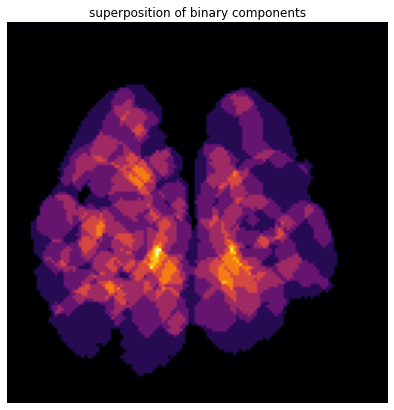

In [32]:
# showing sum of binary components
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (7, 7))
ax.imshow(np.sum(binary_ROIs_clean, axis = 0), cmap='inferno')
ax.set_axis_off()
ax.set_title('superposition of binary components');

# saving image
if True:
    fig.savefig(fname="./figures/wt_210126_P5_scn2a_minus_run345_binary_components_superposition.pdf",
                        dpi=600, format='pdf')

### Connectivity analysis
If adj_matrix in already known and need to be plotted only.   
Below is just example of how parameters need to be setted.

#### Part 1

In [ ]:
# create random adj_matrix
adjc = np.random.randint(low = 0, high = 40, size =(14,14))

# define labels per nodes
all_labels = ['motor_right', 'motor_left', 'somatosensory_right', 'motor_left', 'motor_right',
      'somatosensory_left', 'auditory_right','auditory_left', 
      'visual_right', 'visual_left', 'retrosplenial_right', 'retrosplenial_left', 'visual_right','visual_left']


In [ ]:
# preparing nodes color-position dictionary
# NOTICE key order is matter
unique_labels_config = {'motor':['#43B0E6'], 'somatosensory': ['#3A89B0'],
             'auditory':['#3B697F'], 'visual':['#738A94'], 'retrosplenial':['#A4C0CC']}

In [ ]:
cnn = Connectivity(data = np.random.rand(100,100,10))
cnn.plot_network_graph(adj_matrix=adjc, labels=all_labels, config = unique_labels_config, title = "test")

#### Part 2

In this case adj_matrix is not given and connectivity analysis based on lasso covariance estimation needs to be run first.

In [20]:
# initialize class
cnn = Connectivity(data = deltaf, labels=False)

*********************************************************************************
***** selected dots have to be symmetric between left and right hemispheres *****
*********************************************************************************


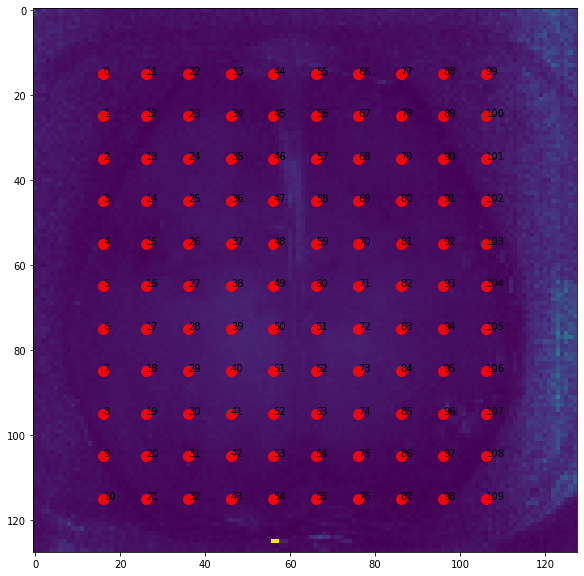

In [21]:
# get location grid on the brain
location_values = cnn.preprocessing(rows_start_end=[15, 125], cols_start_end=[16, 115], resolution=10)

In [23]:
# give labels based on dot number
labels = ['out_left', 'out_left', 'out_left', 'out_left', 'somatosensory_left', 'somatosensory_left', 'somatosensory_left', 'auditory_left', 'auditory_left', 'out_left', 'out_left', 
          'out_left', 'out_left', 'motor_left', 'somatosensory_left', 'somatosensory_left', 'somatosensory_left', 'somatosensory_left', 'visual_left', 'visual_left', 'visual_left', 'out_left', 
          'out_left', 'motor_left', 'motor_left', 'motor_left', 'somatosensory_left','somatosensory_left', 'somatosensory_left', 'somatosensory_left', 'visual_left', 'visual_left', 'visual_left', 
          'motor_left', 'motor_left', 'motor_left', 'motor_left', 'somatosensory_left', 'somatosensory_left', 'somatosensory_left', 'somatosensory_left', 'visual_left', 'visual_left','visual_left', 
          'motor_left', 'motor_left', 'motor_left', 'motor_left', 'motor_left', 'motor_left', 'motor_left', 'retrosplenial_left', 'retrosplenial_left', 'retrosplenial_left', 'out_left', 
          'motor_right', 'motor_right', 'motor_right', 'motor_right', 'motor_right', 'motor_right', 'motor_right', 'retrosplenial_right', 'retrosplenial_right', 'retrosplenial_right', 'out_right', 
          'motor_right', 'motor_right', 'motor_right', 'motor_right', 'somatosensory_right', 'somatosensory_right', 'somatosensory_right', 'somatosensory_right', 'visual_right', 'visual_right','visual_right', 
          'out_right', 'motor_right', 'motor_right', 'motor_right', 'somatosensory_right','somatosensory_right', 'somatosensory_right', 'somatosensory_right', 'visual_right', 'visual_right', 'visual_right', 
          'out_right', 'out_right', 'motor_right', 'somatosensory_right', 'somatosensory_right', 'somatosensory_right', 'somatosensory_right', 'visual_right', 'visual_right', 'visual_right', 'out_right', 
          'out_right', 'out_right', 'out_right', 'out_right', 'somatosensory_right', 'somatosensory_right', 'somatosensory_right', 'auditory_right', 'auditory_right', 'out_right', 'out_right']

In [24]:
# save labels
np.save("./results/connectivity/wt_210126_P5_scn2a_minus_run345_labels.npy", labels)

In [ ]:
# load labels
labels = np.load("./results/connectivity/wt_210126_P5_scn2a_minus_run345_labels.npy")

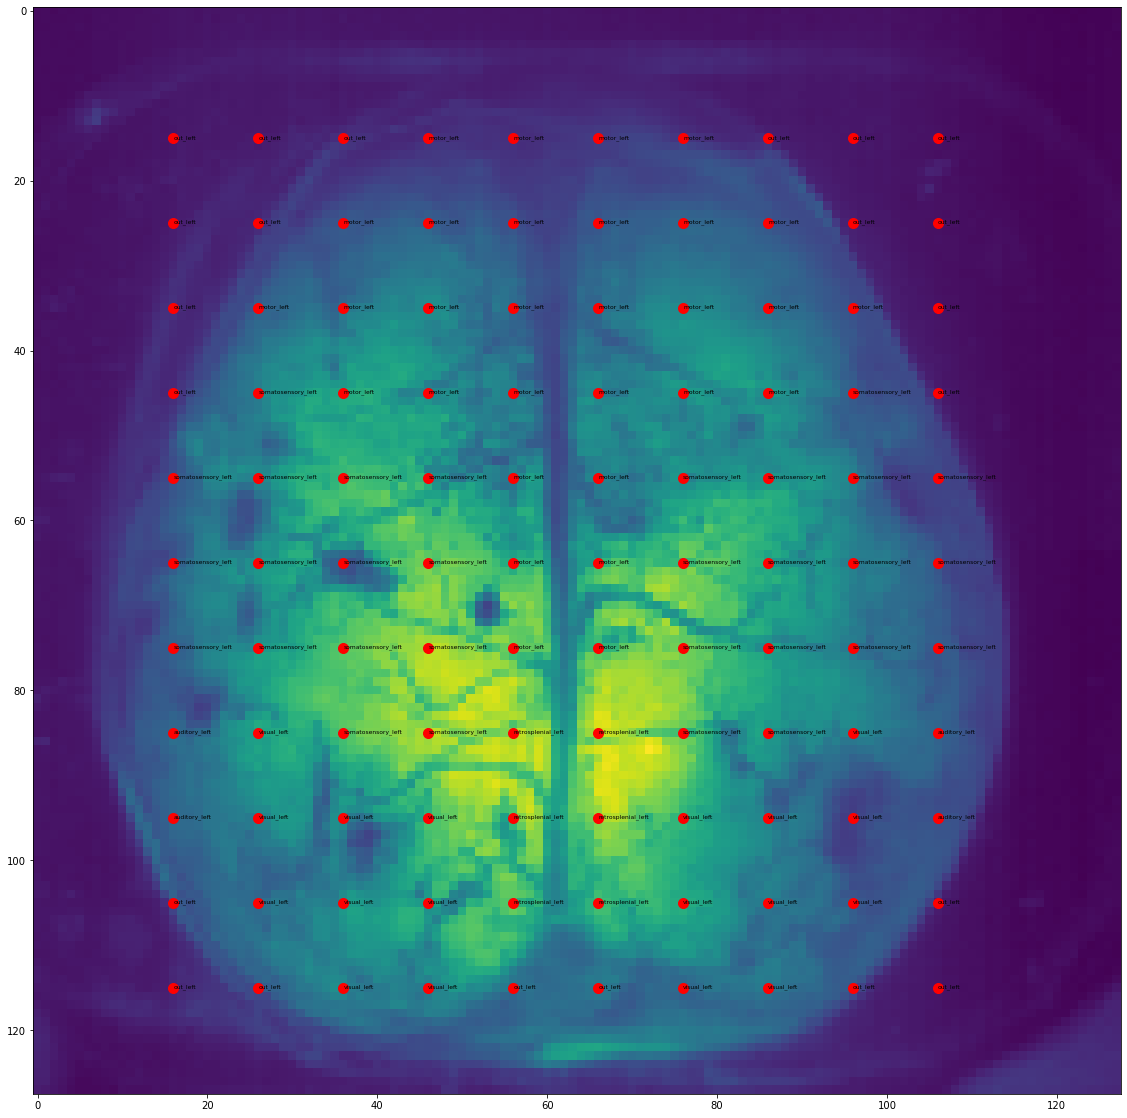

In [14]:
cnn.show_labels(labels=labels, fig_size=(20,20), font_size=6)

In [22]:
# running lasso covariance

start_time = time.clock()
model = cnn.covariance_lasso(location_value=location_values, alpha = 6, max_iter=8000) # running with default values
print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

execution time: 17.0 seconds


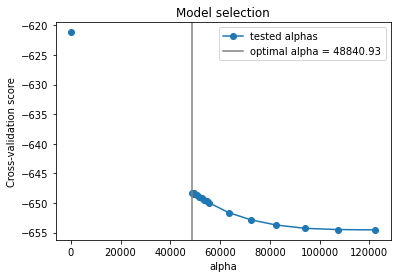

In [16]:
# plot sparsity alpha value
cnn.plot_model_selection()

In [17]:
# preparing nodes color-position dictionary
# NOTICE key order is matter
unique_labels_config = {'out':['#0C0D0D'], 'motor':['#D68080'], 'somatosensory': ['#D6AE80'],
             'auditory':['#96D680'], 'visual':['#80D6B3'], 'retrosplenial':['#80A7D6']}

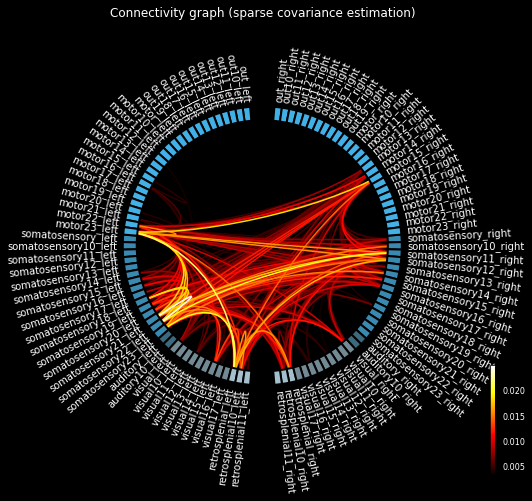

In [29]:
# sparse covariance
cnn.plot_network_graph(adj_matrix=model.covariance_, labels=labels, 
                       config = unique_labels_config, title="Connectivity graph (sparse covariance estimation)", 
                       save_add="./figures/wt_210126_P5_scn2a_minus_run345_connectivity_covariance_n_line(400).pdf", 
                       font_size=10, 
                       fig_size = (10, 10), nr_lines = 400)

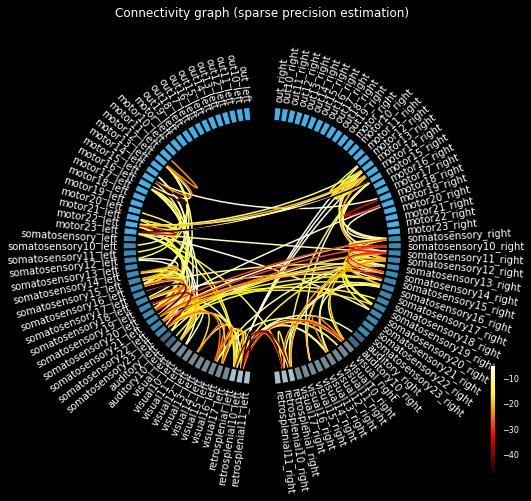

In [30]:
# sparse precision 
cnn.plot_network_graph(adj_matrix=model.precision_, labels=labels, 
                       config = unique_labels_config, title="Connectivity graph (sparse precision estimation)", 
                       save_add="./figures/wt_210126_P5_scn2a_minus_run345_connectivity_precision_n_line(150).pdf", 
                       font_size=10, nr_lines = 150)